<a href="https://colab.research.google.com/github/noviaputri/Time_Series/blob/main/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Novia Putri

Proyek : Membuat Model Machine Learning dengan Data Time Series

In [ ]:
# library yang digunakan
import pandas as pd
import io
import numpy as np
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving energydata_complete.csv to energydata_complete.csv


In [ ]:
# menyimpan dataset dalam pandas dataframe
df = pd.read_csv(io.BytesIO(uploaded['energydata_complete.csv']), parse_dates=['date'])
df

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,55.200000,7.026667,84.256667,17.200000,41.626667,18.2000,48.900000,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,55.200000,6.833333,84.063333,17.200000,41.560000,18.2000,48.863333,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,55.090000,6.560000,83.156667,17.200000,41.433333,18.2000,48.730000,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,55.090000,6.433333,83.423333,17.133333,41.290000,18.1000,48.590000,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,17.200000,55.090000,6.366667,84.893333,17.200000,41.230000,18.1000,48.590000,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,23.200000,52.400000,24.796667,1.000000,24.500000,44.500000,24.7000,50.074000,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,23.230000,52.326667,24.196667,1.000000,24.557143,44.414286,24.7000,49.790000,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,23.230000,52.266667,23.626667,1.000000,24.540000,44.400000,24.7000,49.660000,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,23.200000,52.200000,22.433333,1.000000,24.500000,44.295714,24.6625,49.518750,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


In [ ]:
# melihat info dari dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         19735 non-null  datetime64[ns]
 1   Appliances   19735 non-null  int64         
 2   lights       19735 non-null  int64         
 3   T1           19735 non-null  float64       
 4   RH_1         19735 non-null  float64       
 5   T2           19735 non-null  float64       
 6   RH_2         19735 non-null  float64       
 7   T3           19735 non-null  float64       
 8   RH_3         19735 non-null  float64       
 9   T4           19735 non-null  float64       
 10  RH_4         19735 non-null  float64       
 11  T5           19735 non-null  float64       
 12  RH_5         19735 non-null  float64       
 13  T6           19735 non-null  float64       
 14  RH_6         19735 non-null  float64       
 15  T7           19735 non-null  float64       
 16  RH_7

In [ ]:
# memeriksa jumlah data null
df.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

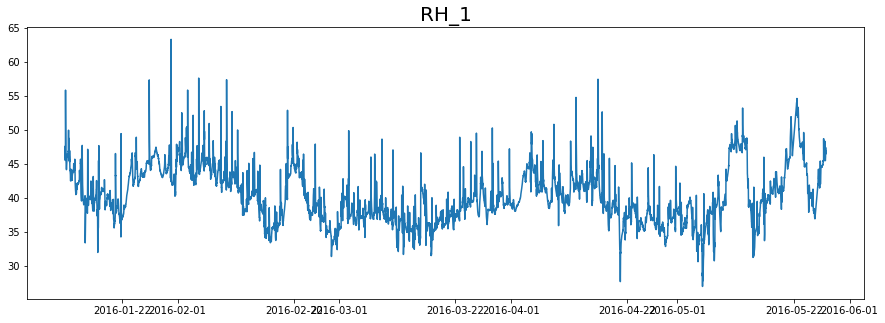

In [ ]:
# membuat plot time series
dates = df['date'].values
humi  = df['RH_1'].values
 
plt.figure(figsize=(15,5))
plt.plot(dates, humi)
plt.title('RH_1',
          fontsize=20);

In [ ]:
# normalisasi dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df['RH_1'] = scaler.fit_transform(df['RH_1'].values.reshape(-1,1))

In [ ]:
# membagi data latih dan data test dengan proporsi 80:20
data_latih, data_test, time_latih, time_test = train_test_split(df['RH_1'], df['date'], test_size=0.2, random_state = 42, shuffle=False)

In [ ]:
# membuat fungsi yang dapat merubah data menjadi format yang dapat diterima oleh model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
# membuat model LSTM
train_set = windowed_dataset(data_latih, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(data_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(6, return_sequences=True),
  tf.keras.layers.LSTM(6),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, validation_data=test_set, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3,
                                                                monitor='val_mae',
                                                                restore_best_weights=True,
                                                                mode='min',
                                                                verbose=1)])

Epoch 1/100
158/158 [==============================] - 15s 68ms/step - loss: 0.0523 - mae: 0.3009 - val_loss: 0.0491 - val_mae: 0.2802
Epoch 2/100
158/158 [==============================] - 10s 63ms/step - loss: 0.0266 - mae: 0.2064 - val_loss: 0.0309 - val_mae: 0.2115
Epoch 3/100
158/158 [==============================] - 10s 63ms/step - loss: 0.0158 - mae: 0.1502 - val_loss: 0.0216 - val_mae: 0.1682
Epoch 4/100
158/158 [==============================] - 10s 64ms/step - loss: 0.0103 - mae: 0.1146 - val_loss: 0.0164 - val_mae: 0.1426
Epoch 5/100
158/158 [==============================] - 10s 62ms/step - loss: 0.0073 - mae: 0.0938 - val_loss: 0.0134 - val_mae: 0.1270
Epoch 6/100
158/158 [==============================] - 10s 63ms/step - loss: 0.0058 - mae: 0.0827 - val_loss: 0.0117 - val_mae: 0.1171
Epoch 7/100
158/158 [==============================] - 10s 63ms/step - loss: 0.0049 - mae: 0.0767 - val_loss: 0.0106 - val_mae: 0.1112
Epoch 8/100
158/158 [==============================] - 

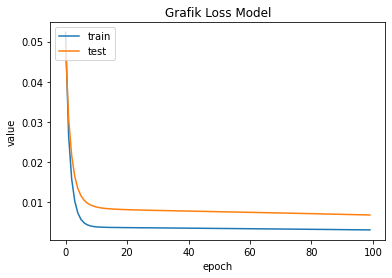

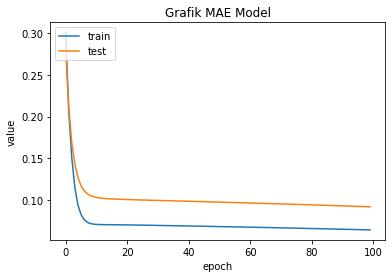

In [ ]:
# plotting nilai loss dan mae model berdasarkan history pada proses pelatihan model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Grafik Loss Model')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

plt.title('Grafik MAE Model')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()